Kelompok Naga 😭😭
- Shafa Diva Syahira - 1301200157 
- Muhammad Fadil Maulana Akbar - 1301204297 
- Alifia Rizqi Adi Winarsasi - 1301204147

### Import Library

In [503]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [504]:
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise import AlgoBase
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.prediction_algorithms.knns import KNNBasic
from surprise import PredictionImpossible
from collections import defaultdict
from sklearn.metrics import ndcg_score

### Read Data

In [505]:
df_recipes = pd.read_csv('recipes.csv')
df_reviews = pd.read_csv('reviews.csv')

In [506]:
df_recipes.head()

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc..."
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",...,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,NaN,"c(""Mix everything together and bring to a boil..."


In [507]:
df_reviews.head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z
4,14,44,2085,Tony Small,5,An excellent dish.,2000-03-28T12:51:00Z,2000-03-28T12:51:00Z


### Reviews Pre-processing

In [508]:
df_reviews_filtered = df_reviews[(df_reviews['DateSubmitted'] >= '2000-01-26') & (df_reviews['DateSubmitted'] <= '2001-12-31')]
df_reviews_filtered['DateSubmitted'] = pd.to_datetime(df_reviews_filtered['DateSubmitted'])
df_reviews_filtered = df_reviews_filtered.sort_values(by=['DateSubmitted'])
df_reviews_filtered

/tmp/ipykernel_4780/889195125.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews_filtered['DateSubmitted'] = pd.to_datetime(df_reviews_filtered['DateSubmitted'])


,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25 09:00:00+00:00,2000-02-25T09:00:00Z
8,22,517,2046,Gay Gilmore ckpt,5,thought this was terrific!,2000-02-25 09:02:00+00:00,2000-02-25T09:02:00Z
9,23,4684,2046,Gay Gilmore ckpt,5,this is absolutely delicious. i even served i...,2000-02-25 09:06:00+00:00,2000-02-25T09:06:00Z
10,24,278,1773,Malarkey Test,4,"a little greasy, but a huge hit with the guests.",2000-03-13 19:53:00+00:00,2000-03-13T19:53:00Z
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13 21:15:00+00:00,2000-03-13T21:15:00Z
...,...,...,...,...,...,...,...,...
4011,6531,11567,20076,Rosemary Chapman,5,My husband (a borderline diabetic) thoroughly ...,2001-12-29 11:11:16+00:00,2001-12-29T11:11:16Z
4019,6540,9836,25925,kat26110,5,very easy and very good!,2001-12-29 11:11:31+00:00,2001-12-29T11:11:31Z
4028,6554,11012,23027,Tootie Capps,5,"excellent, cooked in cast iron skillet and ser...",2001-12-29 11:14:58+00:00,2001-12-29T11:14:58Z
4029,6555,3807,20159,HopeK,4,I baked 1 squash at 350 F. for 45 mins. Proba...,2001-12-29 11:16:30+00:00,2001-12-29T11:16:30Z


In [509]:
df_reviews_cleaned = df_reviews_filtered.drop(['DateSubmitted', 'DateModified', 'ReviewId', 'AuthorName', 'Review'], axis=1)
df_reviews_cleaned

,RecipeId,AuthorId,Rating
2,4523,2046,2
8,517,2046,5
9,4684,2046,5
10,278,1773,4
3,7435,1773,5
...,...,...,...
4011,11567,20076,5
4019,9836,25925,5
4028,11012,23027,5
4029,3807,20159,4


In [510]:
# unique recipes
unique_recipes = df_reviews_cleaned['RecipeId'].unique()
len(unique_recipes)

2517

In [511]:
# sort by recipe id
df_reviews_cleaned = df_reviews_cleaned.sort_values(by=['RecipeId'])
df_reviews_cleaned

,RecipeId,AuthorId,Rating
1901,44,15609,4
3574,44,20780,4
4,44,2085,5
596,44,9816,5
1822,44,18977,5
...,...,...,...
2195,70137,15368,5
2889,109055,21613,4
241899,161382,3737,5
241898,161399,10781,4


<Axes: ylabel='Rating'>

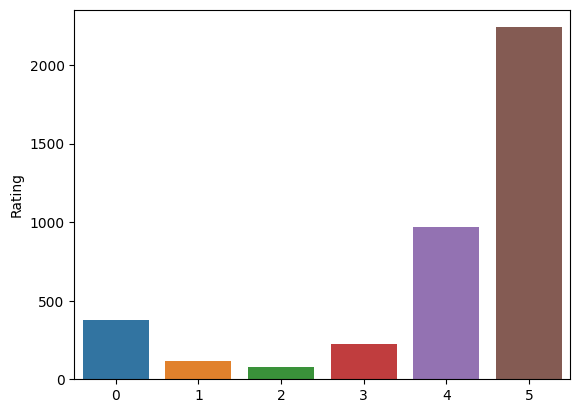

In [512]:
sns.barplot(x=df_reviews_cleaned.Rating.value_counts().index, y=df_reviews_cleaned.Rating.value_counts())

In [513]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X = df_reviews_cleaned[['AuthorId', 'RecipeId']]
y = df_reviews_cleaned['Rating']

X_res, y_res = ros.fit_resample(X, y)

df_resampled = pd.concat([X_res, y_res], axis=1)

# sort by rating
df_resampled = df_resampled.sort_values(by=['Rating'])

<Axes: title={'center': 'Rating Distribution'}, xlabel='Rating', ylabel='Count'>

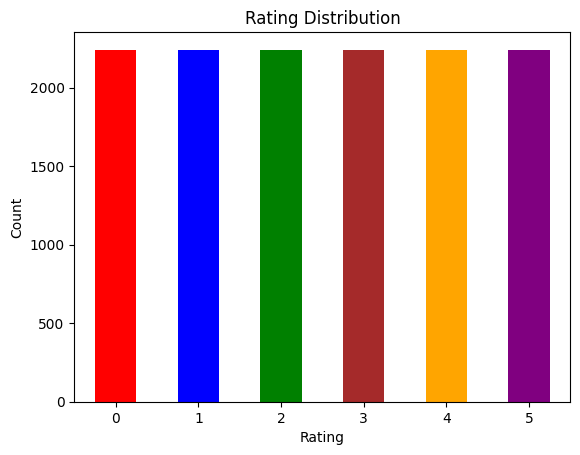

In [514]:
df_resampled['Rating'].value_counts().plot(kind='bar', color=['red', 'blue', 'green', 'brown', 'orange', 'purple'], title='Rating Distribution', rot=0, xlabel='Rating', ylabel='Count')

In [515]:
df_resampled.reset_index(drop=True, inplace=True)
df_resampled

,AuthorId,RecipeId,Rating
0,19569,11907,0
1,14532,11672,0
2,20869,13200,0
3,16305,13685,0
4,3504,4048,0
...,...,...,...
13441,20277,9272,5
13442,20966,9272,5
13443,18947,9272,5
13444,16140,9278,5


### Recipe Preprocessing

In [516]:
# use recipe that recipeId is in df_reviews_cleaned
df_recipes_filtered = df_recipes[df_recipes['RecipeId'].isin(df_reviews_cleaned['RecipeId'])]
df_recipes_filtered

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
6,44,Warm Chicken A La King,1596,Joan Edington,PT3M,PT35M,PT38M,1999-09-17T04:47:00Z,I copied this one out of a friend's book so ma...,"""https://img.sndimg.com/food/image/upload/w_55...",...,31.9,405.8,557.2,29.1,3.1,5.0,45.3,2.0,NaN,"c(""Melt 1 1/2 ozs butter, add the flour and co..."
24,62,"Black Bean, Corn, and Tomato Salad",1570,Dave Miner,PT15M,PT10M,PT25M,1999-08-19T05:12:00Z,"This is easy, delicious, colorful, delicious, ...",character(0),...,2.3,0.0,20.0,55.8,16.6,4.3,17.1,2.0,NaN,"c(""In a bowl whisk together lemon juice, oil, ..."
28,67,Bourbon Pecan Pound Cake,1573,benluc,PT1H,PT1H,PT2H,1999-09-01T09:01:00Z,Make and share this Bourbon Pecan Pound Cake r...,character(0),...,13.6,143.6,441.9,91.2,1.9,62.6,7.8,12.0,NaN,"c(""Combine butter and sugar in bowl of electri..."
33,72,Brownie Pudding,193853,MirandaLee,PT35M,PT40M,PT1H15M,1999-08-20T09:50:00Z,Make and share this Brownie Pudding recipe fro...,character(0),...,3.6,7.8,160.2,34.0,2.1,25.3,2.3,10.0,NaN,"c(""Preheat oven to 350 degrees."", ""Combine flo..."
43,83,Bubble and Squeak,1544,tranch,PT2H27M,PT30M,PT2H57M,1999-08-28T02:59:00Z,Make and share this Bubble and Squeak recipe f...,character(0),...,11.5,54.9,286.1,56.9,7.6,4.9,11.1,4.0,NaN,"c(""Wash potatoes under cold running water then..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65601,70137,Mexicali Spoon Bread Casserole,51579,SilentCricket,PT40M,PT30M,PT1H10M,2003-09-02T20:01:00Z,In the mood for something Mexican and/or cornb...,character(0),...,11.8,171.0,1392.1,34.2,4.3,6.4,32.8,NaN,1 casserole,"c(""Brown beef, onions, green pepper, and garli..."
103405,109055,Mediterranean Penne,148316,- Carla -,PT25M,PT20M,PT45M,2005-01-21T20:03:00Z,"I don't know how this recipe came to be, I've ...","c(""https://img.sndimg.com/food/image/upload/w_...",...,12.6,62.4,1381.2,50.6,8.9,5.1,15.1,6.0,NaN,"c(""In a large pot, cook penne according to pac..."
154014,161382,Island Mango Bread,217657,startnover,NaN,PT10M,PT10M,2006-03-24T15:55:00Z,Lots of flavors come together to make a yummy ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,41.0,431.8,4578.9,455.7,12.8,259.6,44.6,NaN,1 loaf,"c(""Mix sour cream and margarine together and t..."
154031,161399,Sweet Potato and Mango Bake,128473,Baby Kato,PT1H,PT30M,PT1H30M,2006-03-24T16:00:00Z,A nice side dish served with savoury chicken a...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,3.8,15.3,360.6,45.5,4.4,27.6,2.8,4.0,NaN,"c(""Preheat oven to 350°F."", ""Grease pan lightl..."


In [517]:
df_recipes_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2517 entries, 6 to 154041
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   RecipeId                    2517 non-null   int64  
 1   Name                        2517 non-null   object 
 2   AuthorId                    2517 non-null   int64  
 3   AuthorName                  2517 non-null   object 
 4   CookTime                    1941 non-null   object 
 5   PrepTime                    2517 non-null   object 
 6   TotalTime                   2517 non-null   object 
 7   DatePublished               2517 non-null   object 
 8   Description                 2515 non-null   object 
 9   Images                      2517 non-null   object 
 10  RecipeCategory              2517 non-null   object 
 11  Keywords                    2492 non-null   object 
 12  RecipeIngredientQuantities  2517 non-null   object 
 13  RecipeIngredientParts       251

In [518]:
# drop unused columns
columns = ['AuthorId', 'AuthorName', 'Description', 'Images', 'CookTime', 'PrepTime', 'TotalTime', 'DatePublished', 'Images', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'AggregatedRating', 'ReviewCount', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'RecipeYield', 'RecipeInstructions']
df_recipes_filtered = df_recipes_filtered.drop(columns, axis=1)
df_recipes_filtered

,RecipeId,Name,RecipeCategory,Keywords
6,44,Warm Chicken A La King,Chicken,"c(""Poultry"", ""Meat"", ""< 60 Mins"")"
24,62,"Black Bean, Corn, and Tomato Salad",Black Beans,"c(""Corn"", ""Beans"", ""Vegetable"", ""Low Cholester..."
28,67,Bourbon Pecan Pound Cake,Dessert,"c(""Fruit"", ""Nuts"", ""Weeknight"", ""Oven"", ""< 4 H..."
33,72,Brownie Pudding,Dessert,"c(""Low Protein"", ""Healthy"", ""Weeknight"", ""Oven..."
43,83,Bubble and Squeak,Breakfast,"c(""European"", ""Weeknight"", ""Broil/Grill"", ""Ove..."
...,...,...,...,...
65601,70137,Mexicali Spoon Bread Casserole,Oven,"c(""Stove Top"", ""< 4 Hours"")"
103405,109055,Mediterranean Penne,Penne,"c(""Cheese"", ""Vegetable"", ""European"", ""< 60 Mins"")"
154014,161382,Island Mango Bread,Quick Breads,"c(""Breads"", ""Breakfast"", ""Mango"", ""Tropical Fr..."
154031,161399,Sweet Potato and Mango Bake,Yam/Sweet Potato,"c(""Potato"", ""Vegetable"", ""< 4 Hours"")"


In [519]:
df_recipes_filtered['Keywords'] = df_recipes_filtered['Keywords'].str.replace('"', '')
df_recipes_filtered['Keywords'] = df_recipes_filtered['Keywords'].str.replace('c()', '')
df_recipes_filtered['Keywords'] = df_recipes_filtered['Keywords'].str.replace('(', '')
df_recipes_filtered['Keywords'] = df_recipes_filtered['Keywords'].str.replace(')', '')
df_recipes_filtered

/tmp/ipykernel_4780/3208247459.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_recipes_filtered['Keywords'] = df_recipes_filtered['Keywords'].str.replace('c()', '')
/tmp/ipykernel_4780/3208247459.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_recipes_filtered['Keywords'] = df_recipes_filtered['Keywords'].str.replace('(', '')
/tmp/ipykernel_4780/3208247459.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_recipes_filtered['Keywords'] = df_recipes_filtered['Keywords'].str.replace(')', '')


,RecipeId,Name,RecipeCategory,Keywords
6,44,Warm Chicken A La King,Chicken,"Poultry, Meat, < 60 Mins"
24,62,"Black Bean, Corn, and Tomato Salad",Black Beans,"Corn, Beans, Vegetable, Low Cholesterol, Healt..."
28,67,Bourbon Pecan Pound Cake,Dessert,"Fruit, Nuts, Weeknight, Oven, < 4 Hours"
33,72,Brownie Pudding,Dessert,"Low Protein, Healthy, Weeknight, Oven, < 4 Hours"
43,83,Bubble and Squeak,Breakfast,"European, Weeknight, Broil/Grill, Oven, Stove ..."
...,...,...,...,...
65601,70137,Mexicali Spoon Bread Casserole,Oven,"Stove Top, < 4 Hours"
103405,109055,Mediterranean Penne,Penne,"Cheese, Vegetable, European, < 60 Mins"
154014,161382,Island Mango Bread,Quick Breads,"Breads, Breakfast, Mango, Tropial Fruits, Frui..."
154031,161399,Sweet Potato and Mango Bake,Yam/Sweet Potato,"Potato, Vegetable, < 4 Hours"


In [520]:
df_recipes_filtered['Keywords'] = df_recipes_filtered['Keywords'].fillna('')
df_recipes_filtered

,RecipeId,Name,RecipeCategory,Keywords
6,44,Warm Chicken A La King,Chicken,"Poultry, Meat, < 60 Mins"
24,62,"Black Bean, Corn, and Tomato Salad",Black Beans,"Corn, Beans, Vegetable, Low Cholesterol, Healt..."
28,67,Bourbon Pecan Pound Cake,Dessert,"Fruit, Nuts, Weeknight, Oven, < 4 Hours"
33,72,Brownie Pudding,Dessert,"Low Protein, Healthy, Weeknight, Oven, < 4 Hours"
43,83,Bubble and Squeak,Breakfast,"European, Weeknight, Broil/Grill, Oven, Stove ..."
...,...,...,...,...
65601,70137,Mexicali Spoon Bread Casserole,Oven,"Stove Top, < 4 Hours"
103405,109055,Mediterranean Penne,Penne,"Cheese, Vegetable, European, < 60 Mins"
154014,161382,Island Mango Bread,Quick Breads,"Breads, Breakfast, Mango, Tropial Fruits, Frui..."
154031,161399,Sweet Potato and Mango Bake,Yam/Sweet Potato,"Potato, Vegetable, < 4 Hours"


In [521]:
# reset index
df_recipes_filtered.reset_index(drop=True, inplace=True)
df_recipes_filtered

,RecipeId,Name,RecipeCategory,Keywords
0,44,Warm Chicken A La King,Chicken,"Poultry, Meat, < 60 Mins"
1,62,"Black Bean, Corn, and Tomato Salad",Black Beans,"Corn, Beans, Vegetable, Low Cholesterol, Healt..."
2,67,Bourbon Pecan Pound Cake,Dessert,"Fruit, Nuts, Weeknight, Oven, < 4 Hours"
3,72,Brownie Pudding,Dessert,"Low Protein, Healthy, Weeknight, Oven, < 4 Hours"
4,83,Bubble and Squeak,Breakfast,"European, Weeknight, Broil/Grill, Oven, Stove ..."
...,...,...,...,...
2512,70137,Mexicali Spoon Bread Casserole,Oven,"Stove Top, < 4 Hours"
2513,109055,Mediterranean Penne,Penne,"Cheese, Vegetable, European, < 60 Mins"
2514,161382,Island Mango Bread,Quick Breads,"Breads, Breakfast, Mango, Tropial Fruits, Frui..."
2515,161399,Sweet Potato and Mango Bake,Yam/Sweet Potato,"Potato, Vegetable, < 4 Hours"


In [522]:
# find average rating and review count for each recipe from df_reviews_cleaned
# df_rating_average = df_reviews_cleaned.groupby(['RecipeId']).mean()
# df_rating_average = df_rating_average.reset_index()
# df_rating_average

# drop AuthorId column
# df_rating_average = df_rating_average.drop(['AuthorId'], axis=1)
# df_rating_average

In [523]:
# merge df_recipes_filtered and df_rating_average
# df_recipes_filtered = df_recipes_filtered.merge(df_rating_average, on='RecipeId')
# df_recipes_filtered = df_recipes_filtered.rename(columns={'Rating': 'AverageRating'})
# df_recipes_filtered


In [524]:
df_recipes_filtered.reset_index(drop=True, inplace=True)

### Hybrid Recommender System

#### Recipe recommender with TF-IDF

In [525]:
# use tfidf to vectorize recipe name, recipe category, and keywords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# recipe name
tfidf_recipe_name = TfidfVectorizer()
recipe_name_matrix = tfidf_recipe_name.fit_transform(df_recipes_filtered['Name'])
recipe_name_matrix.shape

(2517, 2018)

In [526]:
# recipe category
tfidf_recipe_category = TfidfVectorizer()
recipe_category_matrix = tfidf_recipe_category.fit_transform(df_recipes_filtered['RecipeCategory'])
recipe_category_matrix.shape


(2517, 180)

In [527]:
# keywords
tfidf_keywords = TfidfVectorizer()
keywords_matrix = tfidf_keywords.fit_transform(df_recipes_filtered['Keywords'])
keywords_matrix.shape

(2517, 230)

In [528]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
recipe_name_matrix_scaled = scaler.fit_transform(recipe_name_matrix)
recipe_category_matrix_scaled = scaler.fit_transform(recipe_category_matrix)
keywords_matrix_scaled = scaler.fit_transform(keywords_matrix)

In [529]:
# combine all matrices
from scipy.sparse import hstack

combined_matrix = hstack([recipe_name_matrix, recipe_category_matrix, keywords_matrix])
combined_matrix.shape

(2517, 2428)

In [530]:
# calculate cosine similarity
cosine_sim = cosine_similarity(combined_matrix, combined_matrix)
cosine_sim.shape

(2517, 2517)

In [531]:
# create a Series for recipe names
indices = pd.Series(df_recipes_filtered.index, index=df_recipes_filtered['Name']).drop_duplicates()
indices

Name
Warm Chicken A La King                               0
Black Bean, Corn, and Tomato Salad                   1
Bourbon Pecan Pound Cake                             2
Brownie Pudding                                      3
Bubble and Squeak                                    4
                                                  ... 
Mexicali Spoon Bread Casserole                    2512
Mediterranean Penne                               2513
Island Mango Bread                                2514
Sweet Potato and Mango Bake                       2515
Grilled Lime-Cilantro Chicken With Mango Salsa    2516
Length: 2517, dtype: int64

In [532]:
def get_TFIDF(name, cosine_sim=cosine_sim):
    # get index of recipe that matches name
    idx = indices[name]

    # get similarity scores of all recipes with that recipe
    sim_scores = list(enumerate(cosine_sim[idx]))

    # sort recipes based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # get top 20 similar recipes
    sim_scores = sim_scores[1:21]

    # get recipe indices and scores
    recipe_indices = [i[0] for i in sim_scores]
    similarity_scores = [i[1] for i in sim_scores]
    
    similar_recipes = df_recipes_filtered['Name'].iloc[recipe_indices]
    return recipe_indices, similarity_scores

In [533]:
# random recipe name
name = df_recipes_filtered['Name'][np.random.randint(0, len(df_recipes_filtered))]
recommendations, scores = get_TFIDF(name)
for recipe, score in zip(recommendations, scores):
    print(f"Recipe: {recipe}, Similarity Score: {score}")


Recipe: 2216, Similarity Score: 0.6656236116053986
Recipe: 1555, Similarity Score: 0.6356913808977691
Recipe: 1556, Similarity Score: 0.6200524822194732
Recipe: 1366, Similarity Score: 0.6137949363874072
Recipe: 1568, Similarity Score: 0.5912599104106103
Recipe: 2233, Similarity Score: 0.5876037018430345
Recipe: 1800, Similarity Score: 0.5807819120499195
Recipe: 2200, Similarity Score: 0.5652171020037987
Recipe: 1518, Similarity Score: 0.559842265404972
Recipe: 1558, Similarity Score: 0.5589453983378435
Recipe: 2161, Similarity Score: 0.5536810156677202
Recipe: 1573, Similarity Score: 0.5505864034546148
Recipe: 1758, Similarity Score: 0.5500535267435114
Recipe: 1881, Similarity Score: 0.5489995864013213
Recipe: 1557, Similarity Score: 0.5412109419314559
Recipe: 2172, Similarity Score: 0.5410069971226892
Recipe: 2426, Similarity Score: 0.5402391858859396
Recipe: 1730, Similarity Score: 0.5306638478556378
Recipe: 966, Similarity Score: 0.5289420154776582
Recipe: 1443, Similarity Score: 0

#### Collaborative filtering

##### SVD

In [534]:
# parsing data rating
reader = Reader(rating_scale=(1, 5))

# load dataset
data = Dataset.load_from_df(df_resampled[['AuthorId', 'RecipeId', 'Rating']], reader)

In [535]:
train, test = train_test_split(data, test_size=0.2)

In [536]:
SVD_model = SVD()
SVD_model.fit(train).test(test)

[Prediction(uid=9450, iid=8924, r_ui=5.0, est=2.831129179887637, details={'was_impossible': False}),
 Prediction(uid=22920, iid=167, r_ui=4.0, est=3.4772648912157424, details={'was_impossible': False}),
 Prediction(uid=13483, iid=693, r_ui=4.0, est=3.9185129254821787, details={'was_impossible': False}),
 Prediction(uid=10775, iid=5332, r_ui=3.0, est=2.946831982274685, details={'was_impossible': False}),
 Prediction(uid=8367, iid=54484, r_ui=1.0, est=1.0215621741067864, details={'was_impossible': False}),
 Prediction(uid=21618, iid=12805, r_ui=1.0, est=1.1029011923923349, details={'was_impossible': False}),
 Prediction(uid=27050, iid=15340, r_ui=2.0, est=2.030604119835318, details={'was_impossible': False}),
 Prediction(uid=12619, iid=3711, r_ui=4.0, est=3.185711796939465, details={'was_impossible': False}),
 Prediction(uid=21618, iid=10828, r_ui=1.0, est=1.112888079346478, details={'was_impossible': False}),
 Prediction(uid=16140, iid=10837, r_ui=4.0, est=4.176731193795956, details={'w

In [537]:
results = cross_validate(SVD_model, data, measures=['RMSE', 'MSE'], cv=10, verbose=True) 

Evaluating RMSE, MSE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9297  0.9541  0.9488  0.9437  0.9023  0.9375  0.9157  0.9895  0.9419  0.9632  0.9426  0.0231  
MSE (testset)     0.8643  0.9103  0.9003  0.8905  0.8142  0.8790  0.8385  0.9791  0.8872  0.9277  0.8891  0.0437  
Fit time          0.06    0.06    0.07    0.06    0.06    0.07    0.05    0.06    0.06    0.06    0.06    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    


In [538]:
print('Best fold: ', results['test_rmse'].argmin(axis=0) + 1)
print('RMSE: ', results['test_rmse'].min(axis=0))
print('MSE: ', results['test_mse'].min(axis=0))

Best fold:  5
RMSE:  0.902326414580649
MSE:  0.8141929584499693


In [539]:
def getUserRatingres(user_id, num_recommendations):
    all_item_ids = train.all_items()

    for recipe_id in all_item_ids:
        temp = SVD_model.predict(user_id, recipe_id)

    predictions = [SVD_model.predict(user_id, recipe_id) for recipe_id in all_item_ids]
    predictions.sort(key=lambda x: x.est, reverse=True)
    top_recommendations = predictions[:num_recommendations]
    recommended_recipe_ids = [int(prediction.iid) for prediction in top_recommendations]

    print(f"Top {num_recommendations} recommended recipes for user {user_id}: {recommended_recipe_ids}")

In [540]:
random_user = df_resampled['AuthorId'].sample(n=1).values[0]
getUserRatingres(random_user, 10)

Top 10 recommended recipes for user 16006: [2086, 481, 480, 601, 677, 834, 249, 250, 1595, 280]


In [541]:
def getPredictedRating(user_id, recipe_id):
    return SVD_model.predict(user_id, recipe_id).est

getPredictedRating(13618, 834)

2.7384640024372278

##### KNN Basic

In [542]:
# remove 0 ratings
df_resampled_knn = df_resampled[df_resampled['Rating'] != 0]

In [543]:
data = Dataset.load_from_df(df_resampled_knn[['AuthorId', 'RecipeId', 'Rating']], reader)

In [544]:
param_grid = {'k': [10, 20, 30, 40, 50],
              'min_k': [1, 2, 3, 4, 5],
              'sim_options': {'name': ['msd', 'pearson_baseline', 'cosine', 'pearson'],
                              'user_based': [False, True]}
             }

gs_knn = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=10)
gs_knn.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...


Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd

In [545]:
print(gs_knn.best_score['rmse'])
print(gs_knn.best_params['rmse'])

0.8874930666458394
{'k': 10, 'min_k': 1, 'sim_options': {'name': 'msd', 'user_based': False}}


In [546]:
knn_model = KNNBasic(k=gs_knn.best_params['rmse']['k'],
                      min_k=gs_knn.best_params['rmse']['min_k'],
                      sim_options=gs_knn.best_params['rmse']['sim_options'])

In [547]:
knn_model.fit(train).test(test)

Computing the msd similarity matrix...
Done computing similarity matrix.


[Prediction(uid=9450, iid=8924, r_ui=5.0, est=2.503625883227966, details={'was_impossible': True, 'reason': 'Not enough neighbors.'}),
 Prediction(uid=22920, iid=167, r_ui=4.0, est=4.2, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid=13483, iid=693, r_ui=4.0, est=2.503625883227966, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=10775, iid=5332, r_ui=3.0, est=3.0, details={'actual_k': 7, 'was_impossible': False}),
 Prediction(uid=8367, iid=54484, r_ui=1.0, est=1, details={'actual_k': 10, 'was_impossible': False}),
 Prediction(uid=21618, iid=12805, r_ui=1.0, est=1, details={'actual_k': 10, 'was_impossible': False}),
 Prediction(uid=27050, iid=15340, r_ui=2.0, est=2.0, details={'actual_k': 10, 'was_impossible': False}),
 Prediction(uid=12619, iid=3711, r_ui=4.0, est=4.0, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid=21618, iid=10828, r_ui=1.0, est=1, details={'actual_k': 10, 'was_impossible': False}),
 P

In [548]:
def predict_rating(user_id, item_id):
    print(f"{user_id} rate {item_id}: {knn_model.predict(user_id, item_id).est}")

In [549]:
random_user = df_resampled['AuthorId'].sample(n=1).values[0]
random_item = df_resampled['RecipeId'].sample(n=1).values[0]
predict_rating(random_user, random_item)

26788 rate 4165: 2.503625883227966


#### Most Frequent Items

In [550]:
# make a new dataframe that contains RecipeId and frequency of RecipeId in df_reviews_cleaned
df_recipe_frequency = df_reviews_cleaned['RecipeId'].value_counts().rename_axis('RecipeId').reset_index(name='Frequency')
df_recipe_frequency

,RecipeId,Frequency
0,9272,29
1,12522,24
2,8701,16
3,8554,15
4,8468,15
...,...,...
2512,8755,1
2513,8753,1
2514,8745,1
2515,229,1


In [551]:
# make a new column that contains popularity score of each recipe
df_recipe_frequency['PopularityScore'] = (df_recipe_frequency['Frequency'] / df_recipe_frequency['Frequency'].sum()) * 100
df_recipe_frequency

,RecipeId,Frequency,PopularityScore
0,9272,29,0.723192
1,12522,24,0.598504
2,8701,16,0.399002
3,8554,15,0.374065
4,8468,15,0.374065
...,...,...,...
2512,8755,1,0.024938
2513,8753,1,0.024938
2514,8745,1,0.024938
2515,229,1,0.024938


In [552]:
def calculate_weight(frequency, popularity_score, weight_factor=0.5):
    normalized_frequency = frequency / frequency.max()
    normalized_popularity = popularity_score / popularity_score.max()

    weighted_score = (weight_factor * normalized_frequency) + ((1 - weight_factor) * normalized_popularity)
    
    return weighted_score

In [553]:
df_recipe_frequency['WeightedScore'] = calculate_weight(df_recipe_frequency['Frequency'], df_recipe_frequency['PopularityScore'])
df_recipe_frequency = df_recipe_frequency.sort_values(by=['RecipeId'])
df_recipe_frequency

,RecipeId,Frequency,PopularityScore,WeightedScore
69,44,5,0.124688,0.172414
359,62,2,0.049875,0.068966
1223,67,1,0.024938,0.034483
1027,72,1,0.024938,0.034483
216,83,3,0.074813,0.103448
...,...,...,...,...
124,70137,4,0.099751,0.137931
1186,109055,1,0.024938,0.034483
1185,161382,1,0.024938,0.034483
1184,161399,1,0.024938,0.034483


In [554]:
# average weighted score
average_weighted_score = df_recipe_frequency['WeightedScore'].mean()
average_weighted_score

0.05493677475922349

#### Hybrid Recommendations


In [555]:
#SVD
def getSVDRating(user_id, recipe_id):
    return SVD_model.predict(user_id, recipe_id).est

getSVDRating(13618, 4178)

2.537732310426457

In [556]:
#KNN
def getKNNRating(user_id, item_id):
    print(f"{user_id} rate {item_id}: {knn_model.predict(user_id, item_id).est}")


getKNNRating(13618, 4178)

13618 rate 4178: 2.503625883227966


In [557]:
class HybridCollaborative(AlgoBase):
    def __init__(self, algorithms, sim_options={}):
        AlgoBase.__init__(self)
        self.algorithms = algorithms

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        for algorithm in self.algorithms:
            algorithm.fit(trainset)
        return self

    def estimate(self, u, i):
        sum_scores = 0
        sum_weights = 0
        for algorithm in self.algorithms:
            try:
                result = algorithm.estimate(u, i)
                if isinstance(result, tuple):
                    estimate, confidence = result
                    weight = self.calculate_weight(confidence)
                else:
                    estimate = result
                    weight = 1 
                sum_scores += weight * estimate
                sum_weights += weight
            except PredictionImpossible:
                pass

        return (sum_scores / (sum_weights)) * 1.35

    def calculate_weight(self, confidence):
        # The weight is directly proportional to the confidence
        return confidence if confidence > 0 else 0

    def test(self, testset):
        predictions = [self.estimate(u, i) for (u, i, r) in testset]
        return predictions
    
    def get_top_n(self, predictions, n=10):
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            top_n[uid].append((iid, est))

        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:n]

        return top_n

In [558]:
hybrid_algorithm = HybridCollaborative([SVD_model, knn_model], [0.5, 0.5])
hybrid_algorithm.fit(train)
predictions = hybrid_algorithm.test(test)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [559]:
# make a pipeline for hybridCollaborative TFIDF
def getHybridRating(user_id, recipe_id):
    return hybrid_algorithm.predict(user_id, recipe_id).est

getHybridRating(13618, 4178)

3.985493922456867

In [560]:
def get_Hybrid(user_id,name):
    recommendations, scores = get_TFIDF(name)
    
    predictedRating = []
    
    #get the ratings for each recipe
    for i in range(0, len(recommendations)):
        predictedRating.append(getHybridRating(user_id, recommendations[i]))
    
    similar_recipes = df_recipes_filtered['Name'].iloc[recommendations]
    
    newList = [[x,y,z] for x,y,z in zip(similar_recipes, scores, predictedRating)]
    newList.sort(key = lambda x: x[2],reverse=True)
    
    #get the top 10 recipes
    top10 = newList[:10]
    for i in top10:
        print(f"Recipe: {i[0]}")
    
    # calculate ndcgrecipe_id
    y_true = [i[2] for i in top10]
    y_pred = [i[1] for i in top10]
    print(f'ndcg score: {ndcg_score([y_true], [y_pred])}')

In [561]:
user_id = df_resampled['AuthorId'].sample(n=1).values[0]
name = 'Black Bean, Corn, and Tomato Salad'

print(f'user id: {user_id} recommendation that similar to {name}')
get_Hybrid(user_id, name)

user id: 10943 recommendation that similar to Black Bean, Corn, and Tomato Salad
Recipe: Warm Bean and Tomato Salad with Basil
Recipe: Rice With Vegetables
Recipe: Pasta and Bean Soup
Recipe: Fiesta Vegetable Stuffed Bell Peppers
Recipe: Fresh Tomato and Corn Salad
Recipe: Spicy Pork and Black Bean Chili
Recipe: Hot Bean Compote
Recipe: Summer Corn and Tomato Pasta
Recipe: Orzo Salad With Corn and Cucumber-Feta Dressing
Recipe: Piyaz - Turkish Black Eyed Pea Salad
ndcg score: 0.9822281546614682
